In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lsst.daf.butler import Butler

import sys, logging
from pathlib import Path

proj = Path("/sdf/data/rubin/user/mrakovci/Projects/Asteroid_detection_CNN")

# Make ADCNN importable
sys.path.insert(0, str(proj))

# Make "common.py" (used by simulate_inject.py) importable as a top-level module
sys.path.insert(0, str(proj / "ADCNN" / "data" / "dataset_creation"))

# Your injection code (adjust import path to where ADCNN is on sys.path)
from ADCNN.data.dataset_creation.simulate_inject import one_detector_injection

REPO = "/repo/main"
#COLL = "LSSTComCam/runs/DRP/DP1/w_2025_50/DM-48478"
COLL = "LSSTComCam/runs/DRP/DP1/w_2025_17/DM-50530"
WHERE = ("instrument='LSSTComCam' "
         "AND skymap='lsst_cells_v1' "
         "AND day_obs>=20241101 AND day_obs<=20241127 AND exposure.observation_type='science' AND band in ('u','g','r','i','z','y') "
         "AND (exposure not in (2024110600163, 2024110800318, 2024111200185, 2024111400039, 2024111500225, 2024111500226, 2024111500239, 2024111500240, 2024111500242, "
         "2024111500288, 2024111500289, 2024111800077, 2024111800078, 2024112300230, 2024112400094, 2024112400225, 2024112600327))")

RNG = np.random.default_rng(146)

In [15]:
butler = Butler(REPO, collections=COLL)
N_detectors=5

# Query dataset refs (calexp)
refs = list(butler.registry.queryDatasets("preliminary_visit_image", where=WHERE, findFirst=True))
refs = sorted(refs, key=lambda r: (int(r.dataId["visit"]), int(r.dataId["detector"])))

print("Total refs:", len(refs))
refs_small = list(RNG.choice(refs, size=min(N_detectors, len(refs)), replace=False))  # start small (e.g. 10–30)
print("Using:", len(refs_small))


Total refs: 5643
Using: 5


In [17]:
# Injection hyperparams (match what you used before)
N_INJECT = 20
TRAIL_LEN = [6, 60]
MAG = [19, 25]         # allow bright/faint; you will later filter 20-21
BETA = [0, 180]
SOURCE_TYPE = "preliminary_visit_image" # keep consistent with your pipeline

dimensions = butler.get("preliminary_visit_image.dimensions", dataId=refs_small[0].dataId)
imgs, masks, cats, source_masks , matched_fp_masks= np.empty((dimensions.y, dimensions.x, len(refs_small))), np.empty((dimensions.y, dimensions.x, len(refs_small))), [], np.empty((dimensions.y, dimensions.x, len(refs_small))), np.empty((dimensions.y, dimensions.x, len(refs_small)))

logger = logging.getLogger("lsst")
logger.setLevel(logging.ERROR)

for k, ref in enumerate(refs_small, 1):
    res = one_detector_injection(
        n_inject=N_INJECT,
        trail_length=TRAIL_LEN,
        mag=MAG,
        beta=BETA,
        repo=REPO,
        coll=COLL,
        dimensions=dimensions,
        source_type=SOURCE_TYPE,
        ref_dataId=ref.dataId,
        debug=True)
    if res is None:
        continue

    imgs[:,:,k-1], masks[:,:,k-1], cat, source_masks[:,:,k-1], matched_fp_masks[:,:,k-1] = res
    df = cat.to_pandas()
    df["image_id"] = k - 1
    # Standardize column name
    if "stack_detection" in df.columns and "stack_detected" not in df.columns:
        df["stack_detected"] = df["stack_detection"].astype(bool)
    cats.append(df)
    print ("\r", k, "/", len(refs_small), "done", end="")
cat = pd.concat(cats, ignore_index=True)

 5 / 5 done

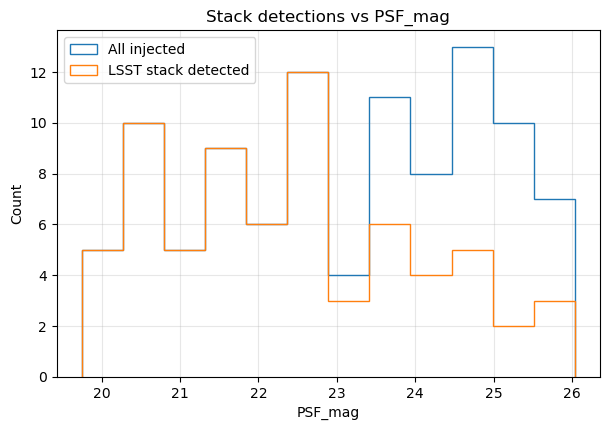

In [18]:
def plot_stack_vs_psfmag(cat, bins=12, title="Stack detections vs PSF_mag"):
    field = "PSF_mag"
    vals = cat[field].to_numpy()
    vals = vals[np.isfinite(vals)]
    edges = np.histogram_bin_edges(vals, bins=bins)

    fig, ax = plt.subplots(figsize=(7,4.5))
    ax.hist(cat[field], bins=edges, histtype="step", label="All injected")
    ax.hist(cat.loc[cat["stack_detected"], field], bins=edges, histtype="step", label="LSST stack detected")
    ax.set_xlabel("PSF_mag")
    ax.set_ylabel("Count")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend()
    return fig, ax, edges

fig, ax, edges = plot_stack_vs_psfmag(cat, bins=12)
plt.show()


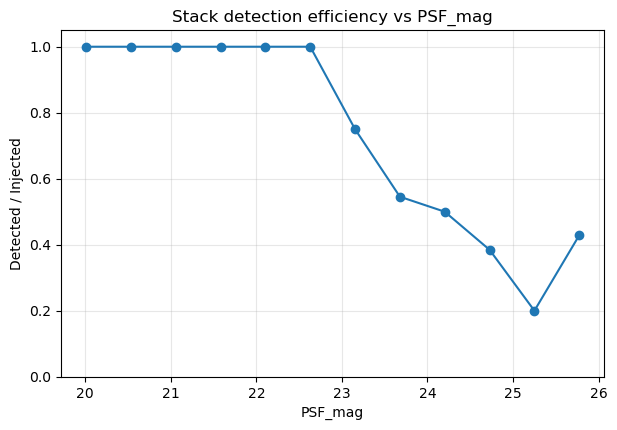

In [19]:
def plot_stack_efficiency(cat, edges, title="Stack detection efficiency vs PSF_mag"):
    field = "PSF_mag"
    all_counts, _ = np.histogram(cat[field], bins=edges)
    det_counts, _ = np.histogram(cat.loc[cat["stack_detected"], field], bins=edges)
    eff = det_counts / np.maximum(all_counts, 1)

    centers = 0.5*(edges[:-1] + edges[1:])
    fig, ax = plt.subplots(figsize=(7,4.5))
    ax.plot(centers, eff, marker="o")
    ax.set_xlabel("PSF_mag")
    ax.set_ylabel("Detected / Injected")
    ax.set_ylim(0, 1.05)
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    return fig, ax

fig, ax = plot_stack_efficiency(cat, edges)
plt.show()


Rows in PSF_mag bin: 15
Stack detected fraction: 1.0


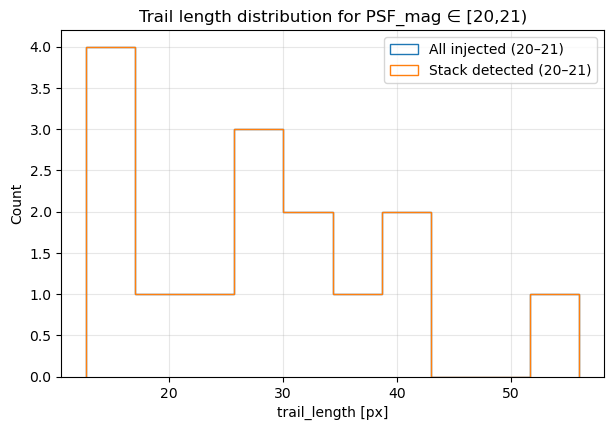

In [20]:
m0, m1 = 20.0, 21.0
sel = cat["PSF_mag"].between(m0, m1, inclusive="left") & np.isfinite(cat["trail_length"])
cat_bin = cat.loc[sel].copy()

print("Rows in PSF_mag bin:", len(cat_bin))
print("Stack detected fraction:", cat_bin["stack_detected"].mean() if len(cat_bin) else np.nan)

def plot_traillen_in_magbin(cat_bin, bins=12, title=None):
    field = "trail_length"
    vals = cat_bin[field].to_numpy()
    edges = np.histogram_bin_edges(vals[np.isfinite(vals)], bins=bins)

    fig, ax = plt.subplots(figsize=(7,4.5))
    ax.hist(cat_bin[field], bins=edges, histtype="step", label="All injected (20–21)")
    ax.hist(cat_bin.loc[cat_bin["stack_detected"], field], bins=edges, histtype="step", label="Stack detected (20–21)")
    ax.set_xlabel("trail_length [px]")
    ax.set_ylabel("Count")
    ax.set_title(title or "Trail length distribution for PSF_mag ∈ [20,21)")
    ax.grid(True, alpha=0.3)
    ax.legend()
    return fig, ax, edges

fig, ax, tl_edges = plot_traillen_in_magbin(cat_bin, bins=10)
plt.show()


Detected examples: 10 Missed examples: 0


/tmp/ipykernel_10148/2863365388.py:37: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


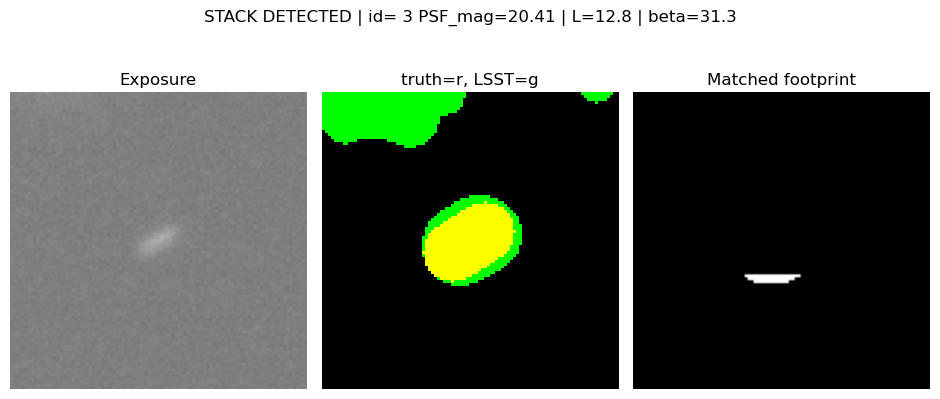

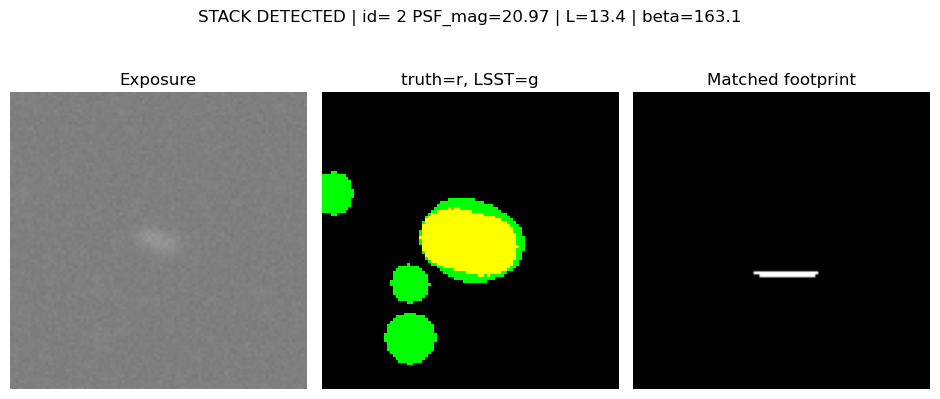

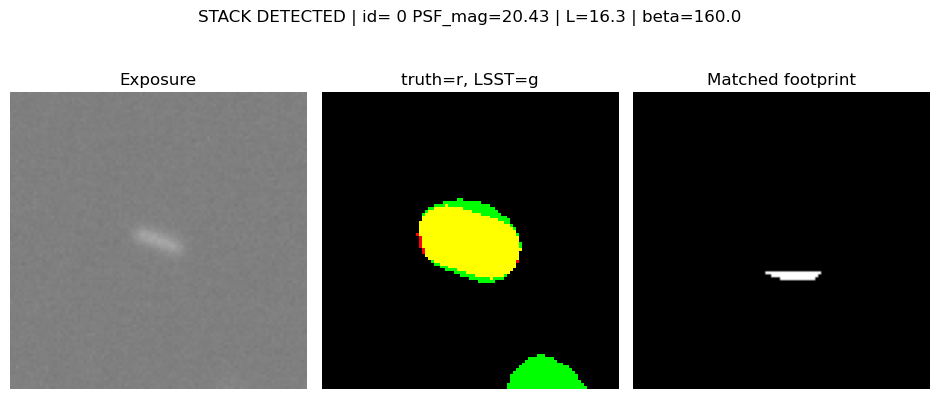

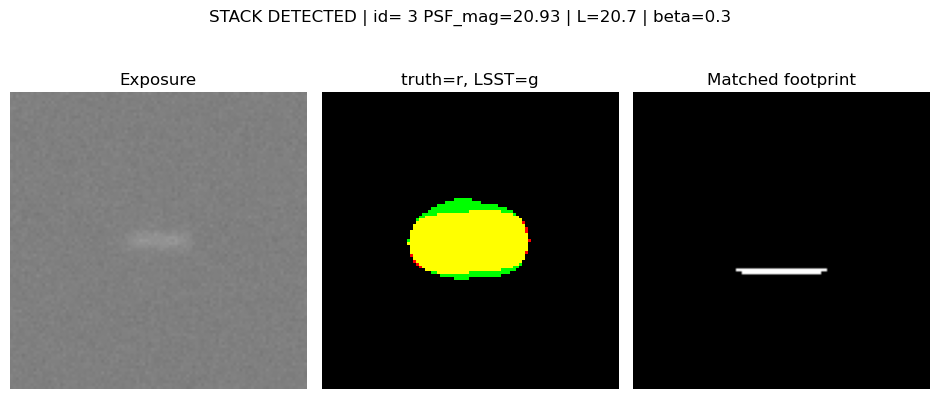

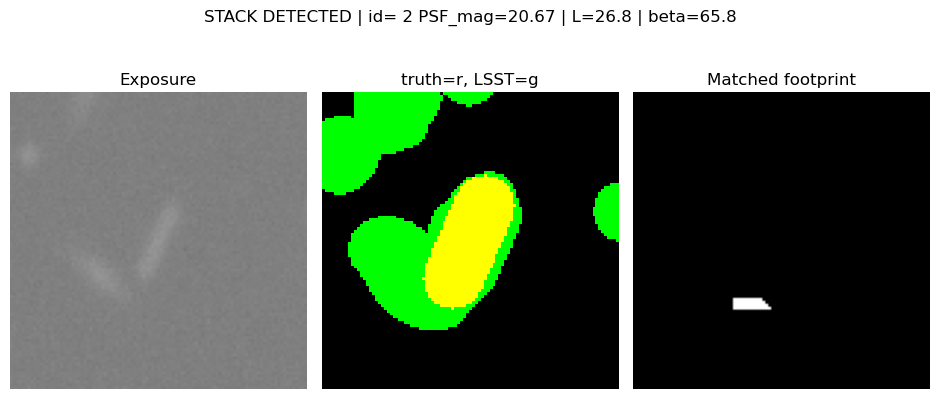

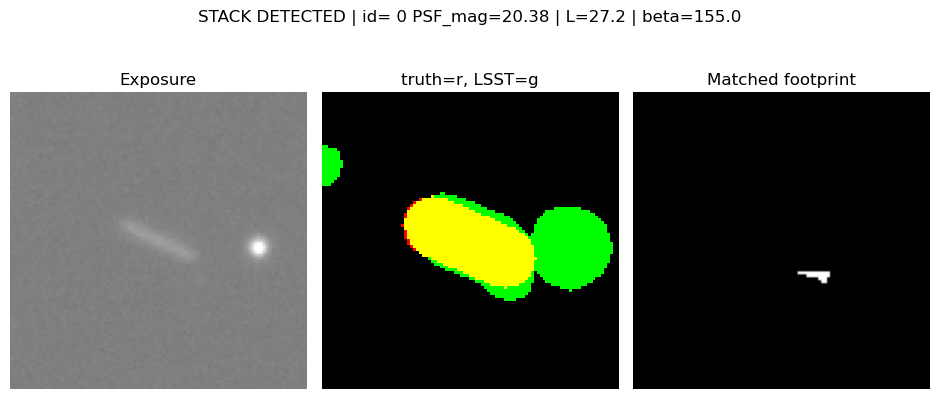

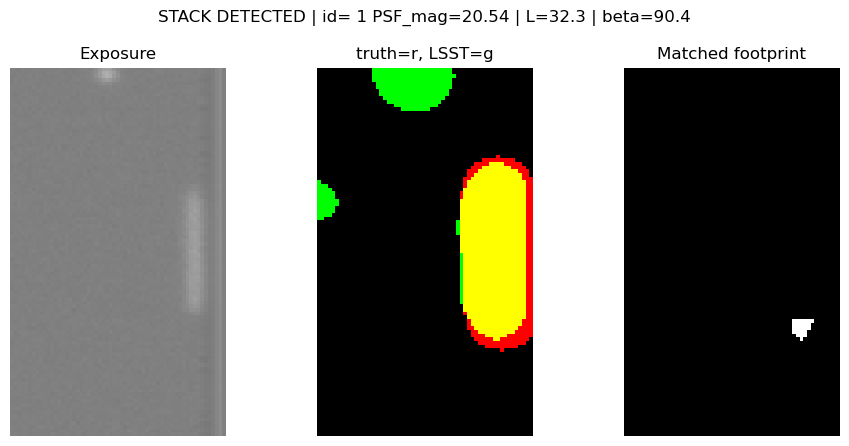

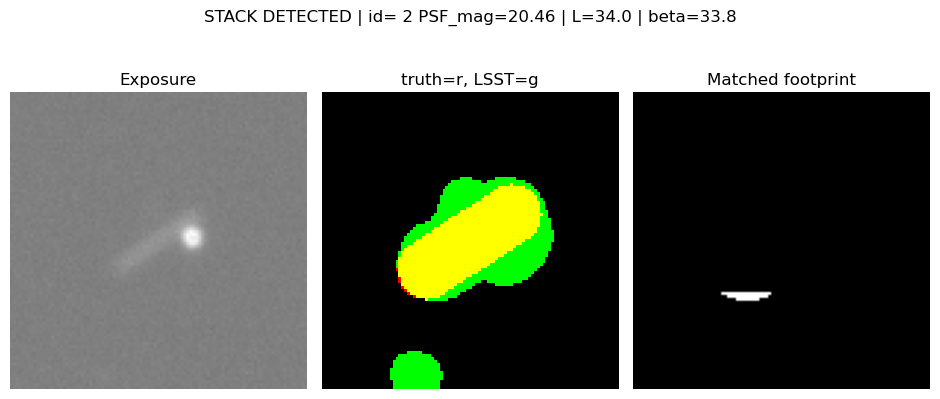

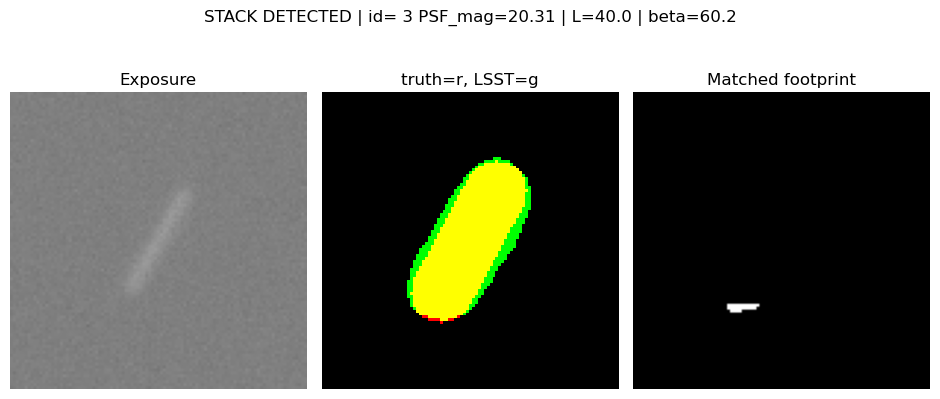

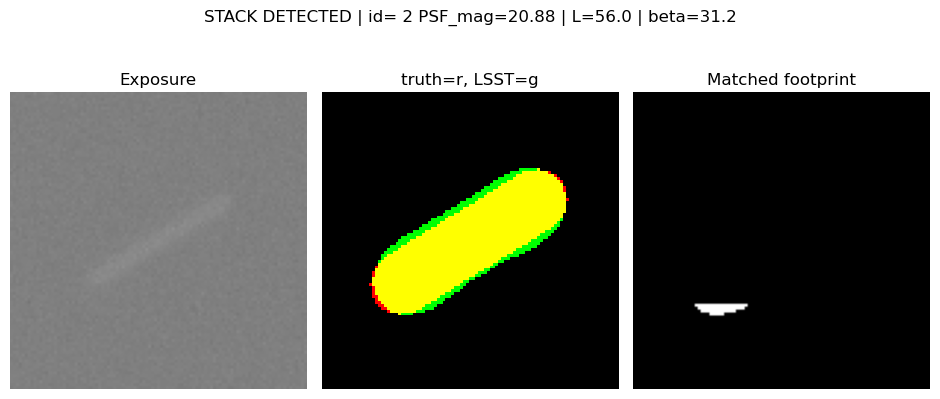

In [21]:
def show_cutout(image, truth_mask, lsst_mask, x, y, footprint=None, r=40, title="", st_dev=0):
    x = int(round(x)); y = int(round(y))
    H, W = image.shape
    x0, x1 = max(0, x-r), min(W, x+r+1)
    y0, y1 = max(0, y-r), min(H, y+r+1)

    img_c = image[y0:y1, x0:x1]
    t_c   = truth_mask[y0:y1, x0:x1].astype(bool)
    l_c   = lsst_mask[y0:y1, x0:x1].astype(bool)

    if st_dev == 0:
        vmin, vmax = np.nanpercentile(img_c, [5, 99.5])
    else:
        vmin, vmax = (-st_dev, st_dev)

    # Build RGB composite mask: truth->R, lsst->G, overlap->(R+G)=yellow
    rgb = np.zeros((img_c.shape[0], img_c.shape[1], 3), dtype=float)
    rgb[..., 0] = t_c.astype(float)   # red
    rgb[..., 1] = l_c.astype(float)   # green
    # rgb[..., 2] left as 0 (blue)
    if footprint is not None: 
        fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(9.5, 4.5), constrained_layout=True)
    else:
        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9.5, 4.5), constrained_layout=True)
    fig.suptitle(title if title else "Image")
    ax0.imshow(img_c, origin="lower", vmin=vmin, vmax=vmax, cmap="gray")
    ax0.axis("off")
    ax0.set_title("Exposure")

    ax1.imshow(rgb, origin="lower", interpolation="nearest")
    ax1.set_title("truth=r, LSST=g")
    ax1.axis("off")
    if footprint is not None:
        ax2.imshow(footprint[y0:y1, x0:x1], origin="lower", cmap="gray")
        ax2.axis("off")
        ax2.set_title("Matched footprint")
    fig.tight_layout()
    plt.show()

def pick_examples(cat_bin, n_each=10):
    det = cat_bin[cat_bin["stack_detected"]].copy()
    miss = cat_bin[~cat_bin["stack_detected"]].copy()

    # Prefer “representative” examples (middle trail lengths) rather than extremes:
    det = det.sort_values("trail_length")
    miss = miss.sort_values("trail_length")

    det_ex = det.iloc[np.linspace(0, max(len(det)-1,0), num=min(n_each,len(det)), dtype=int)] if len(det) else det
    miss_ex = miss.iloc[np.linspace(0, max(len(miss)-1,0), num=min(n_each,len(miss)), dtype=int)] if len(miss) else miss
    return det_ex, miss_ex

det_ex, miss_ex = pick_examples(cat_bin, n_each=10)

print("Detected examples:", len(det_ex), "Missed examples:", len(miss_ex))

for _, row in det_ex.iterrows():
    img = imgs[:, :, int(row["image_id"])]
    truth_mask = masks[:, :, int(row["image_id"])]
    det_mask = source_masks[:, :, int(row["image_id"])]
    show_cutout(
        img,
        truth_mask=truth_mask,
        lsst_mask=det_mask,
        footprint = matched_fp_masks[:, :, int(row["image_id"])],
        x=row["x"], y=row["y"],
        r=50,
        title=f"STACK DETECTED | id= {row['image_id']:d} PSF_mag={row['PSF_mag']:.2f} | L={row['trail_length']:.1f} | beta={row['beta']:.1f}",
        st_dev = 5 * np.std(imgs)
    )

for _, row in miss_ex.iterrows():
    img = imgs[:, :, int(row["image_id"])]
    truth_mask = masks[:, :, int(row["image_id"])]
    det_mask = source_masks[:, :, int(row["image_id"])]
    show_cutout(
        img,
        truth_mask=truth_mask,
        lsst_mask=det_mask,
        footprint = matched_fp_masks[:, :, int(row["image_id"])],
        x=row["x"], y=row["y"],
        r=50,
        title=f"STACK MISSED | id= {row['image_id']:d} PSF_mag={row['PSF_mag']:.2f} | L={row['trail_length']:.1f} | beta={row['beta']:.1f}",
        st_dev = 5 * np.std(imgs)
    )


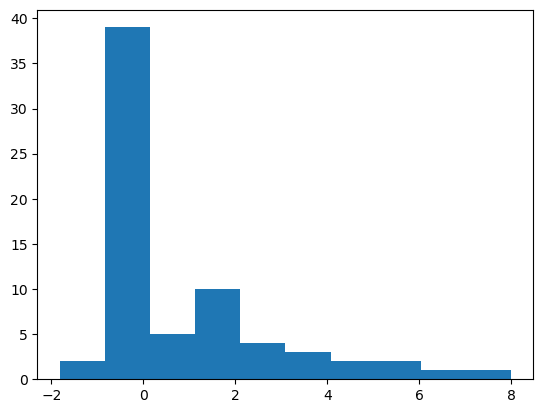

In [10]:
_  = plt.hist(cat.dropna()["PSF_mag"]-cat.dropna()["stack_mag"], bins=10)

In [18]:
np.median(cat.dropna()["PSF_mag"]-cat.dropna()["stack_mag"])

np.float64(-0.03992285279921148)

(array([ 4.,  8.,  8., 13., 12., 16.,  9., 14.,  8.,  8.]),
 array([22.02138343, 22.74375069, 23.46611795, 24.18848521, 24.91085248,
        25.63321974, 26.355587  , 27.07795426, 27.80032153, 28.52268879,
        29.24505605]),
 <BarContainer object of 10 artists>)

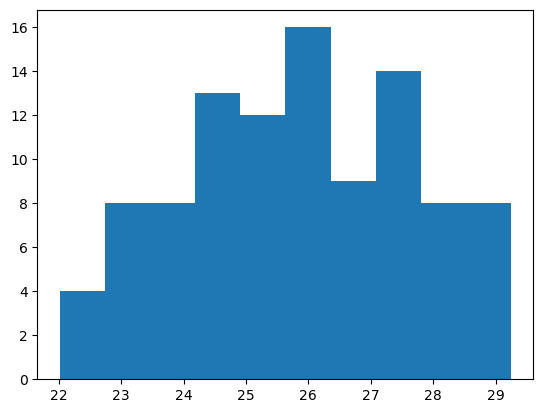

In [17]:
plt.hist(cat["mag"])